# Part 4: Clustering & Segmentation

This notebook applies unsupervised clustering techniques to segment users based on their transactional and behavioral features.  
The goal is to uncover meaningful groups of users that can inform personalization, marketing strategy, and product recommendations.

## Files Used (inputs)

- `user_features.pkl` – Aggregated user-level statistics (orders, basket size, reorder ratio, etc.)
- `up.pkl` – User × Product interaction features

## Outputs

- Cluster assignments for each user (`user_cluster_base`)
- Elbow curve and silhouette score diagnostics
- Final KMeans model (raw features and PCA-reduced space)
- Cluster profiles and comparative method analysis
- Recommendation for best clustering approach

## Workflow Summary

### 1) Data Preparation
- Merged `user_features` with `uxp_summary` on `user_id`
- Dropped identifier column (`user_id`) for clustering input
- Standardized features with `StandardScaler`

### 2) KMeans (Raw Feature Space)
- Tested **k = 2 to 5** using inertia and silhouette scores
- Results:
**Decision:**  
While k=2 gave the highest silhouette, it oversimplified the segmentation.  
**k=3 selected** for interpretable low–medium–high engagement clusters.

### 3) KMeans (PCA-Reduced Space)
- Reduced dimensions (95% variance retained) for clustering and visualization
- Silhouette Score: **0.3865** (significantly better than raw space)
- Produced balanced, well-separated clusters with clearer profiles

### 4) DBSCAN
- Without PCA: produced many small/noisy clusters; silhouette: **-0.3548**
- With PCA: slight improvement but still poor (silhouette: **-0.2375**)
- **Conclusion:** DBSCAN not suitable for this dataset

### 5) Cluster Profiling
- **Cluster 0 (~33%)**: High-order volume users, large baskets, consistent reorders
- **Cluster 1 (~17%)**: Medium engagement, occasional large baskets, moderate reorders
- **Cluster 2 (~50%)**: Low-order users, small baskets, limited engagement

## Comparative Analysis

- **KMeans (raw)** : Simple, interpretable, however Lower silhouette (0.17–0.25) **[Works, weaker fit]**
- **KMeans (PCA)** : Best balance of cohesion + interpretability **0.3865** **[Recommended]**
- **DBSCAN** : Non-parametric, flexible shapes however Poor fit in high-dim sparse data **[Not suitable]**

## Conclusion

**KMeans with PCA** is the recommended clustering approach.  
It provides clearer cluster separation, higher silhouette score (**0.3865**), and meaningful segmentation that can be directly applied for marketing and personalization strategies.

## Cluster Profiling (KMeans + PCA)

**Cluster 0 – Heavy loyal shoppers (42,851 users, ~21%)**  
- Large baskets (avg ~136 items, ~450 distinct products)  
- Frequent orders (~9 day gap)  
- Strong reorder ratio (\~70%) but diverse baskets → lower per-product reorder ratio (~0.10)
- High total reorders (~314)  
- Represents **loyal heavy shoppers** with broad product coverage  

**Cluster 1 – Core regular users (95,720 users, ~46%)**  
- Medium baskets (~53 items, ~100 distinct products)  
- Moderate frequency (~12.5 day gap)  
- Reorder ratio ~48%, avg product reorder ratio ~0.22  
- Stable but not extreme behavior  
- Represents the **largest, steady user base**  

**Cluster 2 – Low-engagement / light users (67,638 users, ~33%)**  
- Small baskets (~35 items, ~54 distinct products)  
- Infrequent orders (~24 day gap)  
- Lowest reorder ratio (~38%), weak loyalty (per-product reorder ratio ~0.31)  
- Limited engagement, fewer reorders  
- Represents **infrequent or newer shoppers**

## Cluster Profile Insights

**Cluster 0: High-value segment → Can be target with loyalty programs, premium products, exclusive offers.**

**Cluster 1: Largest steady base → Great for personalized cross-sell and product recommendations.**

**Cluster 2: At-risk users → need re-engagement campaigns, onboarding, and discounts.**

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.stats import entropy
import sys

In [111]:
user_features = pd.read_pickle('user_features.pkl')

In [112]:
up = pd.read_pickle('up.pkl')

In [113]:
user_features.head()

,user_id,user_total_orders,user_total_products,user_distinct_products,user_avg_basket_size,user_avg_days_between_orders,user_avg_order_hour,user_most_common_dow,user_reorder_ratio,user_min_order_gap,user_max_order_gap,user_avg_order_gap,user_median_days_between_orders,user_weekend_order_ratio,user_most_common_order_hour,user_hour_std,user_hour_entropy
0,1,10,59,18,3.277778,20.259259,10.542373,4,0.759259,0.0,30.0,20.259259,20.5,0.000000,7,3.500355,2.659844
1,2,14,195,102,1.911765,15.967033,10.441026,2,0.510989,3.0,30.0,15.967033,13.0,0.000000,9,1.649854,2.097470
2,3,12,88,33,2.666667,11.487179,16.352273,0,0.705128,7.0,21.0,11.487179,10.0,0.522727,16,1.454599,2.477860
3,4,5,18,17,1.058824,15.357143,13.111111,4,0.071429,0.0,21.0,15.357143,20.0,0.222222,15,1.745208,1.571542
4,5,4,37,23,1.608696,14.500000,15.729730,3,0.538462,10.0,19.0,14.500000,11.0,0.243243,18,2.588958,1.531887


In [114]:
#Aggregate UXP behavior per user
uxp_summary = up.groupby('user_id').agg(
    avg_up_order_count=('up_order_count', 'mean'),
    avg_up_cart_position=('up_avg_cart_position', 'mean'),
    total_up_reordered=('up_total_reordered', 'sum'),
    avg_up_reorder_ratio=('up_reorder_ratio', 'mean'),
    avg_up_order_rate=('up_order_rate_since_first', 'mean'),
    avg_up_orders_since_last=('up_orders_since_last', 'mean'),
    avg_up_days_since_last=('up_days_since_last_order', 'mean')
).reset_index()


In [115]:
uxp_summary.head()

,user_id,avg_up_order_count,avg_up_cart_position,total_up_reordered,avg_up_reorder_ratio,avg_up_order_rate,avg_up_orders_since_last,avg_up_days_since_last
0,1,3.277778,4.409259,41,0.327778,0.574846,2.833333,123.222222
1,2,1.911765,9.636516,93,0.136555,0.306680,4.911765,105.205882
2,3,2.666667,5.096801,55,0.222222,0.283413,5.212121,71.818182
3,4,1.058824,2.676471,1,0.211765,0.441176,2.000000,34.882353
4,5,1.608696,5.409420,14,0.402174,0.597826,1.086957,24.608696


In [116]:
user_cluster_base = user_features.merge(uxp_summary, on='user_id', how='inner')

In [117]:
user_cluster_base.head()

,user_id,user_total_orders,user_total_products,user_distinct_products,user_avg_basket_size,user_avg_days_between_orders,user_avg_order_hour,user_most_common_dow,user_reorder_ratio,user_min_order_gap,...,user_most_common_order_hour,user_hour_std,user_hour_entropy,avg_up_order_count,avg_up_cart_position,total_up_reordered,avg_up_reorder_ratio,avg_up_order_rate,avg_up_orders_since_last,avg_up_days_since_last
0,1,10,59,18,3.277778,20.259259,10.542373,4,0.759259,0.0,...,7,3.500355,2.659844,3.277778,4.409259,41,0.327778,0.574846,2.833333,123.222222
1,2,14,195,102,1.911765,15.967033,10.441026,2,0.510989,3.0,...,9,1.649854,2.097470,1.911765,9.636516,93,0.136555,0.306680,4.911765,105.205882
2,3,12,88,33,2.666667,11.487179,16.352273,0,0.705128,7.0,...,16,1.454599,2.477860,2.666667,5.096801,55,0.222222,0.283413,5.212121,71.818182
3,4,5,18,17,1.058824,15.357143,13.111111,4,0.071429,0.0,...,15,1.745208,1.571542,1.058824,2.676471,1,0.211765,0.441176,2.000000,34.882353
4,5,4,37,23,1.608696,14.500000,15.729730,3,0.538462,10.0,...,18,2.588958,1.531887,1.608696,5.409420,14,0.402174,0.597826,1.086957,24.608696


In [118]:
from sklearn.preprocessing import StandardScaler

# Droping user_id, save it for later
user_ids = user_cluster_base['user_id']
X_cluster = user_cluster_base.drop(columns=['user_id'])

# Standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [119]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_cluster.columns)
X_scaled_df.head()

,user_total_orders,user_total_products,user_distinct_products,user_avg_basket_size,user_avg_days_between_orders,user_avg_order_hour,user_most_common_dow,user_reorder_ratio,user_min_order_gap,user_max_order_gap,...,user_most_common_order_hour,user_hour_std,user_hour_entropy,avg_up_order_count,avg_up_cart_position,total_up_reordered,avg_up_reorder_ratio,avg_up_order_rate,avg_up_orders_since_last,avg_up_days_since_last
0,-0.335662,-0.481321,-0.822308,0.789468,0.664536,-1.354032,0.688806,1.248357,-0.854038,0.555775,...,-1.566546,0.128253,0.357391,0.789468,-0.718378,-0.326724,0.778822,0.956096,-0.437166,0.429740
1,-0.095490,0.184668,0.661995,-0.179068,0.069007,-1.399716,-0.242798,0.098146,-0.458181,0.555775,...,-1.066496,-1.118007,-0.386565,-0.179068,0.622210,0.001558,-0.655414,-0.492950,-0.115093,0.160673
2,-0.215576,-0.339308,-0.557254,0.356176,-0.552554,1.264846,-1.174403,0.997573,0.069629,-0.796688,...,0.683678,-1.249506,0.116648,0.356176,-0.542050,-0.238341,-0.012879,-0.618672,-0.068550,-0.337960
3,-0.635877,-0.682097,-0.839979,-0.783823,-0.015613,-0.196144,0.688806,-1.938292,-0.854038,-0.796688,...,0.433653,-1.053789,-1.082307,-0.783823,-1.162771,-0.579250,-0.091314,0.233809,-0.566300,-0.889582
4,-0.695920,-0.589054,-0.733957,-0.393951,-0.134538,0.984228,0.223004,0.225423,0.465486,-1.097235,...,1.183728,-0.485547,-1.134766,-0.393951,-0.461876,-0.497179,1.336817,1.080272,-0.707785,-1.043016


KMeans

k |      inertia     | silhouette
2 |        3523933 |     0.2482
3 |        3062117 |     0.1700
4 |        2754562 |     0.1738
5 |        2585696 |     0.1379


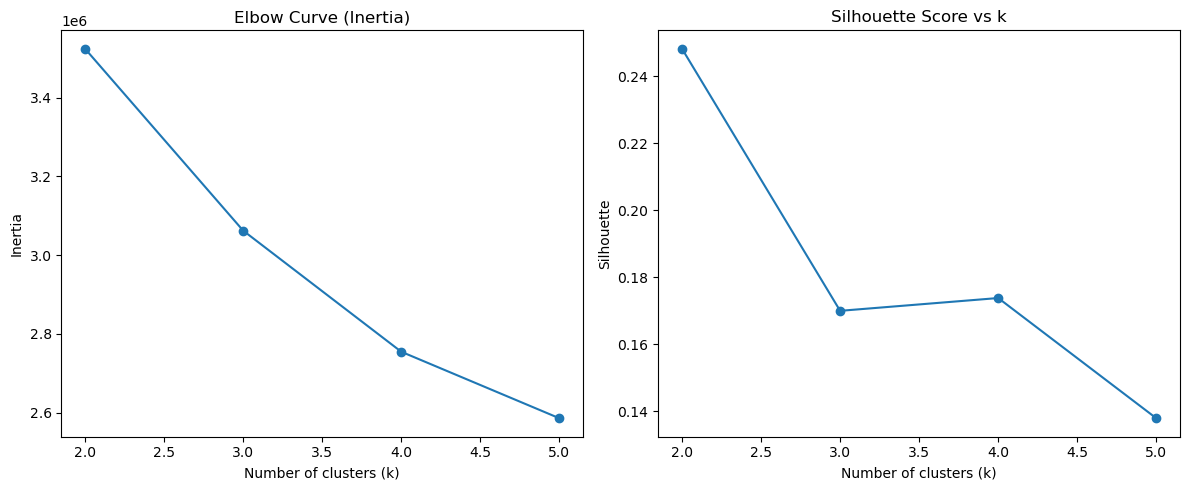

In [121]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

X_mat = X_scaled

k_range = range(2, 6)  # try k = 2..10
inertias, sil_scores = [], []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_mat)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_mat, labels))

# Quick table for comparing silhouette scores at different K
print("k |      inertia     | silhouette")
for k, i, s in zip(k_range, inertias, sil_scores):
    print(f"{k:<1} | {i:>14.0f} | {s:>10.4f}")

# Plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(k_range), inertias, marker='o')
plt.title('Elbow Curve (Inertia)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(list(k_range), sil_scores, marker='o')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette')

plt.tight_layout()
plt.show()


#### I chose k=3 because:

#### **Elbow curve support** – The inertia curve shows a sharper bend at k=3, suggesting diminishing returns beyond that point.

#### **Interpretability** – Two clusters often just split the data into "low vs. high" groups, while three clusters allow more nuanced segmentation (e.g., low–medium–high engagement users).

#### **Balance** – With k=3, cluster sizes are better balanced compared to k=2, which can produce one dominant cluster and one small one.

#### **Business value** – For downstream insights (like marketing or personalization), having 3 distinct customer/user groups is more actionable than a simple binary split.

In [123]:
# Fitting final KMeans with chosen k and attach labels
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

CHOSEN_K = 3  

kmeans_final = KMeans(n_clusters=CHOSEN_K, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(X_scaled_df.values)

# Attaching labels
user_cluster_base = user_cluster_base.copy()
user_cluster_base['cluster'] = final_labels

# Cluster sizes
print("\nCluster sizes:")
print(user_cluster_base['cluster'].value_counts().sort_index())



Cluster sizes:
cluster
0     67588
1     34645
2    103976
Name: count, dtype: int64


In [124]:
cluster_profiles = user_cluster_base.groupby('cluster').mean().round(2)
cluster_profiles

,user_id,user_total_orders,user_total_products,user_distinct_products,user_avg_basket_size,user_avg_days_between_orders,user_avg_order_hour,user_most_common_dow,user_reorder_ratio,user_min_order_gap,...,user_most_common_order_hour,user_hour_std,user_hour_entropy,avg_up_order_count,avg_up_cart_position,total_up_reordered,avg_up_reorder_ratio,avg_up_order_rate,avg_up_orders_since_last,avg_up_days_since_last
cluster,,,,,,,,,,,,,,,,,,,,,
0,103306.37,5.20,48.55,32.71,1.53,23.33,13.68,2.53,0.37,13.82,...,13.40,2.90,1.76,1.53,6.51,15.83,0.32,0.55,1.68,56.97
1,102882.75,45.08,499.13,143.30,3.94,8.37,13.28,2.38,0.72,1.32,...,12.87,3.79,3.31,3.94,9.16,355.83,0.10,0.19,16.53,192.60
2,103048.16,12.52,114.07,58.98,1.99,12.73,13.55,2.56,0.49,3.41,...,13.31,3.42,2.49,1.99,7.01,55.10,0.20,0.37,4.61,86.10


PCA + Kmeans

In [127]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reducing to 2D for clustering
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# Running KMeans
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_pca.fit(X_pca_2d)

# Evaluating
labels_pca = kmeans_pca.labels_
score = silhouette_score(X_pca_2d, labels_pca)
print(f"Silhouette Score in PCA space: {score:.4f}")


Silhouette Score in PCA space: 0.3865


In [128]:
user_cluster_base['cluster'] = kmeans_final.labels_

In [129]:
clusters_full = user_cluster_base['cluster'].values

In [130]:
user_cluster_base['pca_cluster'] = kmeans_pca.labels_

In [131]:
clusters_pca = user_cluster_base['pca_cluster'].values

In [132]:
# Creating PCA cluster profiles
pca_cluster_profiles = user_cluster_base.groupby('pca_cluster').mean().round(2)

# Adding counts and proportions
pca_cluster_profiles['num_users'] = user_cluster_base['pca_cluster'].value_counts().sort_index().values
pca_cluster_profiles['pct_users'] = (pca_cluster_profiles['num_users'] / user_cluster_base.shape[0]).round(3)

# Display
pca_cluster_profiles

,user_id,user_total_orders,user_total_products,user_distinct_products,user_avg_basket_size,user_avg_days_between_orders,user_avg_order_hour,user_most_common_dow,user_reorder_ratio,user_min_order_gap,...,avg_up_order_count,avg_up_cart_position,total_up_reordered,avg_up_reorder_ratio,avg_up_order_rate,avg_up_orders_since_last,avg_up_days_since_last,cluster,num_users,pct_users
pca_cluster,,,,,,,,,,,,,,,,,,,,,
0,102916.13,41.14,449.87,135.64,3.68,9.07,13.33,2.39,0.70,1.48,...,3.68,8.99,314.22,0.10,0.19,15.14,186.33,1.19,42851,0.208
1,103027.77,11.21,99.62,53.32,1.93,12.49,13.52,2.59,0.48,3.61,...,1.93,6.80,46.31,0.22,0.39,4.09,76.18,1.91,95720,0.464
2,103333.96,5.60,53.54,35.37,1.53,23.74,13.72,2.51,0.38,13.68,...,1.53,6.66,18.18,0.31,0.53,1.86,62.09,0.13,67638,0.328


In [172]:
# Cluster sizes
print("\nCluster sizes:")
print(user_cluster_base['pca_cluster'].value_counts().sort_index())


Cluster sizes:
pca_cluster
0    42851
1    95720
2    67638
Name: count, dtype: int64


### Cluster Profiling (KMeans + PCA)

**Cluster 0 – Heavy loyal shoppers (42,851 users, ~21%)**  
- Large baskets (avg ~136 items, ~450 distinct products)  
- Frequent orders (~9 day gap)  
- Strong reorder ratio (~70%) but diverse baskets → lower per-product reorder ratio (~0.10)  
- High total reorders (~314)  
- Represents **loyal heavy shoppers** with broad product coverage  

**Cluster 1 – Core regular users (95,720 users, ~46%)**  
- Medium baskets (~53 items, ~100 distinct products)  
- Moderate frequency (~12.5 day gap)  
- Reorder ratio ~48%, avg product reorder ratio ~0.22  
- Stable but not extreme behavior  
- Represents the **largest, steady user base**  

**Cluster 2 – Low-engagement / light users (67,638 users, ~33%)**  
- Small baskets (~35 items, ~54 distinct products)  
- Infrequent orders (~24 day gap)  
- Lowest reorder ratio (~38%), weak loyalty (per-product reorder ratio ~0.31)  
- Limited engagement, fewer reorders  
- Represents **infrequent or newer shoppers**


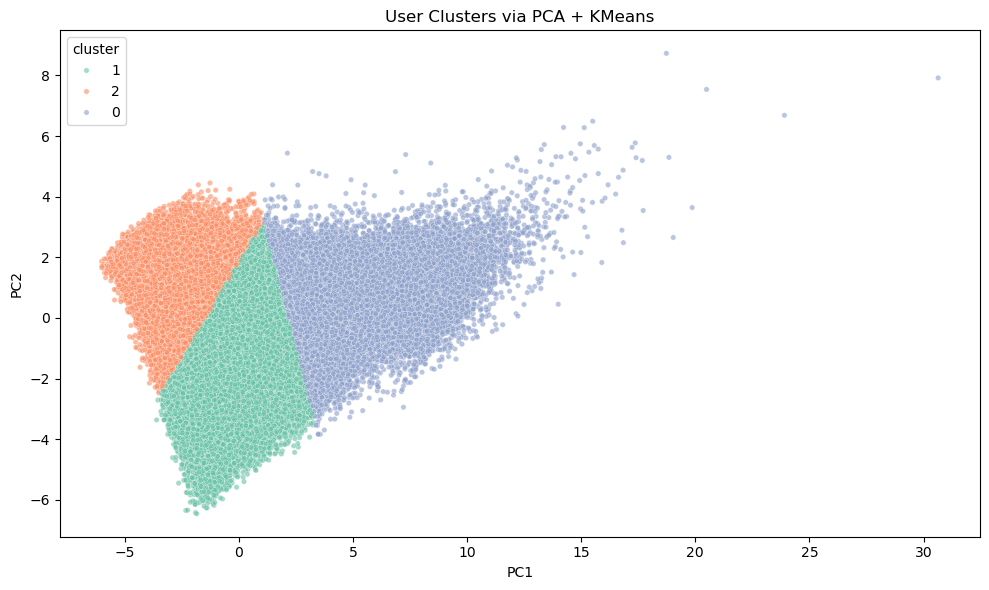

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

# PCA scatter plot with cluster labels
plot_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
plot_df['cluster'] = user_cluster_base['pca_cluster'].astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='cluster', palette='Set2', s=15, alpha=0.6)
plt.title("User Clusters via PCA + KMeans")
plt.tight_layout()
plt.show()


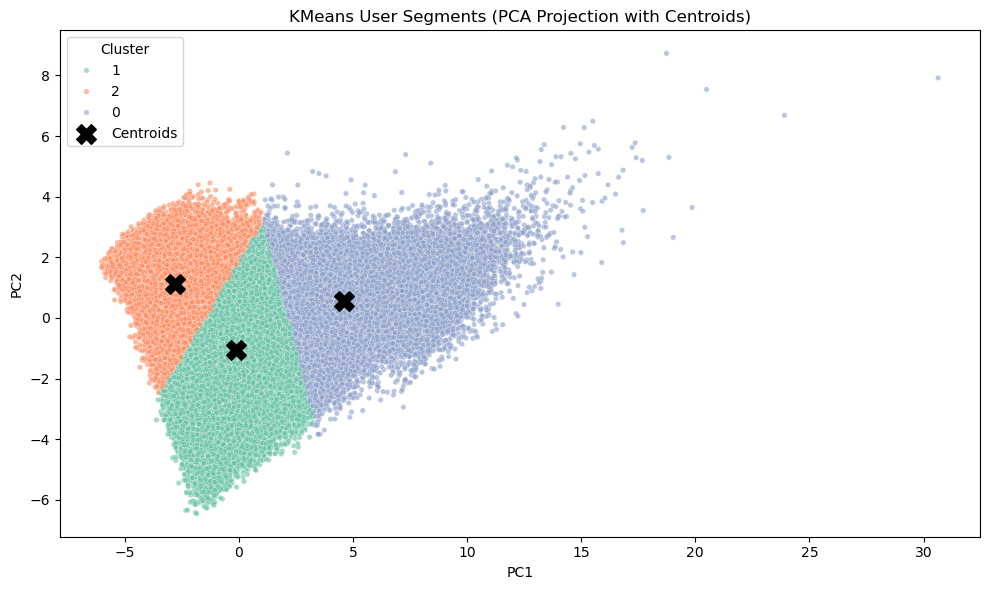

In [134]:
# Plotting with centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='cluster', palette='Set2', s=15, alpha=0.6)

# Plotting centroids directly (already in PCA space)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], 
            kmeans_pca.cluster_centers_[:, 1], 
            marker='X', s=200, c='black', label='Centroids')

plt.title("KMeans User Segments (PCA Projection with Centroids)")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


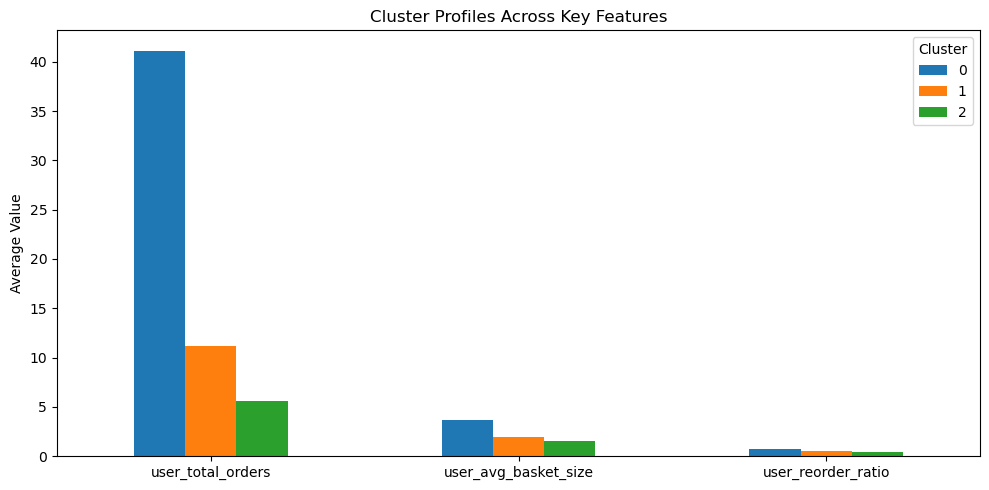

In [135]:
import matplotlib.pyplot as plt

features_to_plot = ['user_total_orders', 'user_avg_basket_size', 'user_reorder_ratio']
pca_cluster_profiles[features_to_plot].T.plot(kind='bar', figsize=(10, 5))
plt.title('Cluster Profiles Across Key Features')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


dbscan

In [137]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Initial DBSCAN run
dbscan = DBSCAN(eps=1.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

# Assigning to user_cluster_base
user_cluster_base['dbscan_cluster'] = db_labels

# Counting how many points in each cluster
print(user_cluster_base['dbscan_cluster'].value_counts().sort_index())

# computing silhouette score (exclude noise)
mask = db_labels != -1
if np.any(mask):
    sil_score = silhouette_score(X_scaled[mask], db_labels[mask])
    print(f"Silhouette Score (DBSCAN, excluding noise): {sil_score:.4f}")
else:
    print("All points classified as noise (-1). Try different eps/min_samples.")


dbscan_cluster
-1       38470
 0      166882
 1           5
 2          28
 3           4
         ...  
 143         5
 144         5
 145         4
 146         4
 147         5
Name: count, Length: 149, dtype: int64
Silhouette Score (DBSCAN, excluding noise): -0.3548


In [138]:
from sklearn.decomposition import PCA

# Reducing dimensions with PCA
pca = PCA(n_components=0.95, random_state=42)  # retain 95% variance
X_pca = pca.fit_transform(X_scaled)

print(f"PCA-reduced shape: {X_pca.shape}")



PCA-reduced shape: (206209, 12)


In [139]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Run DBSCAN on PCA-reduced data
dbscan_pca = DBSCAN(eps=1.5, min_samples=5)
db_labels_pca = dbscan_pca.fit_predict(X_pca)

# Assigning labels
user_cluster_base['dbscan_pca_cluster'] = db_labels_pca

# Cluster counts
print(user_cluster_base['dbscan_pca_cluster'].value_counts().sort_index())

# Silhouette score (excluding noise)
mask = db_labels_pca != -1
if np.any(mask):
    sil_pca = silhouette_score(X_pca[mask], db_labels_pca[mask])
    print(f"Silhouette Score (PCA + DBSCAN): {sil_pca:.4f}")
else:
    print("All points classified as noise.")

dbscan_pca_cluster
-1      12798
 0     193091
 1         38
 2          3
 3         16
 4          4
 5          4
 6          5
 7          5
 8          2
 9         16
 10         6
 11         3
 12         7
 13         7
 14        12
 15         4
 16         4
 17         5
 18        13
 19         4
 20         6
 21         5
 22         7
 23         8
 24         5
 25         5
 26         4
 27        10
 28         9
 29         6
 30         4
 31         7
 32         3
 33         5
 34         4
 35         5
 36         3
 37         5
 38         2
 39         4
 40         6
 41         3
 42         3
 43         3
 44         4
 45         6
 46         3
 47         4
 48         5
 49         2
 50         5
 51         6
 52         5
Name: count, dtype: int64
Silhouette Score (PCA + DBSCAN): -0.2375
